In [ ]:
!huggingface-cli login

In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
pip install accelerate -U

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss

In [3]:
ds = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [6]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    cm = confusion_matrix(labels, preds)

    fpr, tpr, _ = roc_curve(labels, pred.predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    fpr_specificity = 1 - specificity

    logloss = log_loss(labels, pred.predictions)

    beta = 2
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    mcc = (cm[0, 0] * cm[1, 1] - cm[0, 1] * cm[1, 0]) / np.sqrt((cm[0, 0] + cm[0, 1]) * (cm[0, 0] + cm[1, 0]) * (cm[1, 1] + cm[0, 1]) * (cm[1, 1] + cm[1, 0]))

    gmean = np.sqrt(recall * specificity)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'fpr': fpr_specificity,
        'log_loss': logloss,
        'f2_score': f2_score,
        'mcc': mcc,
        'gmean': gmean,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

In [7]:
model_name = "FacebookAI/roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
def tokenize(examples):
    outputs = tokenizer(examples['text'], truncation=True)
    return outputs

tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
training_args = TrainingArguments(num_train_epochs=1,
                                  output_dir="distilbert-imdb",
                                  push_to_hub=True,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  evaluation_strategy="epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
trainer = Trainer(model=model, tokenizer=tokenizer,
                  data_collator=data_collator,
                  args=training_args,
                  train_dataset=tokenized_ds["train"],
                  eval_dataset=tokenized_ds["test"],
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.196900,0.170706,0.939440


<ipython-input-12-0ee186c2f32d>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


TrainOutput(global_step=1563, training_loss=0.2529289803288338, metrics={'train_runtime': 3203.1891, 'train_samples_per_second': 7.805, 'train_steps_per_second': 0.488, 'total_flos': 6515172397265280.0, 'train_loss': 0.2529289803288338, 'epoch': 1.0})

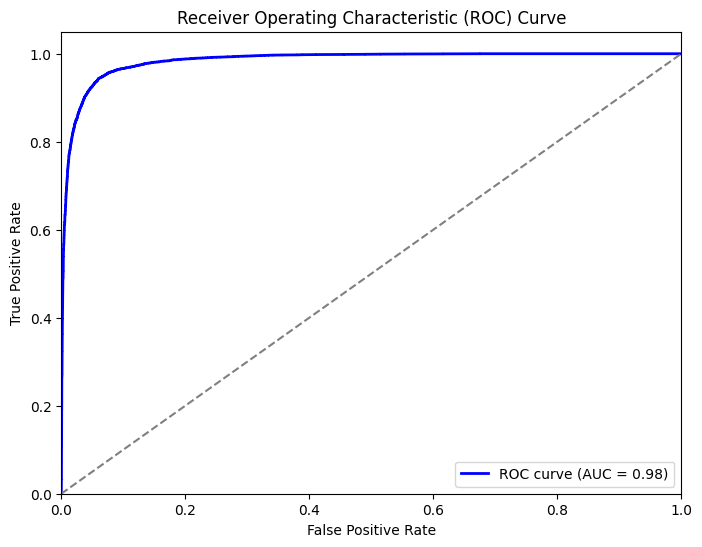

Trainer is attempting to log a value of "[[11836   664]
 [  850 11650]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:
results = trainer.evaluate()

In [ ]:
results

{'eval_loss': 0.1707061529159546,
 'eval_accuracy': 0.93944,
 'eval_precision': 0.9395373198919615,
 'eval_recall': 0.93944,
 'eval_f1': 0.9394366476004166,
 'eval_confusion_matrix': array([[11836,   664],
        [  850, 11650]]),
 'eval_roc_auc': 0.9840449792,
 'eval_runtime': 842.8004,
 'eval_samples_per_second': 29.663,
 'eval_steps_per_second': 1.855}